In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import glob
import pickle
import numpy as np
import sys, os
import pylab
import time 
import scipy.misc
import matplotlib
import re
from PIL import Image

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Lambda,Input, concatenate, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.utils import np_utils 
from keras import optimizers 
from keras.models import load_model
from keras.models import model_from_json

import keras.backend as K 
K.set_image_dim_ordering('tf')
print('Image ordering is tf check: ',K.image_dim_ordering())
list_of_losses = []

Using TensorFlow backend.


Image ordering is tf check:  tf


In [2]:
import csv
bbox_path = 'formatted_csv.csv'
csv_as_list = []
with open(bbox_path) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        csv_as_list.append(row)
csv_as_list = csv_as_list[1:]
print(csv_as_list[:5])
print(len(csv_as_list))

[['00013118_008.png', '1024', '1024', 'Atelectasis', '225.084745762712', '547.019216763771', '311.8644067796611', '626.2056574417371'], ['00014716_007.png', '1024', '1024', 'Atelectasis', '686.101694915254', '131.543498411017', '871.593220338983', '445.03502383474597'], ['00029817_009.png', '1024', '1024', 'Atelectasis', '221.830508474576', '317.053115068856', '376.949152542373', '534.0022676112291'], ['00014687_001.png', '1024', '1024', 'Atelectasis', '726.237288135593', '494.951420153602', '867.254237288135', '550.273454051907'], ['00017877_001.png', '1024', '1024', 'Atelectasis', '660.067796610169', '569.78078654661', '860.745762711864', '647.8824814618642']]
984


In [3]:
disease_label_dict = {"Infiltrate":0,"Mass":1,"Nodule":2,"Cardiomegaly":3,"Atelectasis":4,"Effusion":5,"Pneumonia":6,"Pneumothorax":7}

In [4]:
#train/test split
train_csv_output = []
train_name = os.listdir("train/")
for information in csv_as_list:
    if information[0] in train_name:
        train_csv_output.append(information)
print(len(train_csv_output))

850


In [5]:
#train/test split
test_csv_output = []
test_name = os.listdir("test/")
for information in csv_as_list:
    if information[0] in test_name:
        test_csv_output.append(information)
print(len(test_csv_output))
print(test_csv_output[1][0])

129
00000181_061.png


In [6]:
img = scipy.misc.imread(os.path.join("train/",csv_as_list[1][0]))
print(img)
print(len(img))
print(len(img[0]))
print(img.shape)
img.reshape(1024,1024)

[[  0   1   3 ...   3   4   4]
 [  0   2   5 ...   5   6   7]
 [  0   2   5 ...   5   6   7]
 ...
 [  0  12  41 ... 151 151 162]
 [  0   8  27 ... 131 131 133]
 [  0   0   0 ...   0   0   0]]
1024
1024
(1024, 1024)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


array([[  0,   1,   3, ...,   3,   4,   4],
       [  0,   2,   5, ...,   5,   6,   7],
       [  0,   2,   5, ...,   5,   6,   7],
       ...,
       [  0,  12,  41, ..., 151, 151, 162],
       [  0,   8,  27, ..., 131, 131, 133],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [10]:
Y = np.zeros((16,16,1))
Y_backup = np.zeros((16,16,1))
Y_label_vectors = []
classification_labels = []
X = []

#Randomizing the images
select_images = list(range(850))

N_img = 1

for i in select_images: #the random output index
    img_name = train_csv_output[i][0]
    xmin = float(train_csv_output[i][4])
    ymin = float(train_csv_output[i][5])
    xmax = float(train_csv_output[i][6])
    ymax = float(train_csv_output[i][7])
    disease_label = train_csv_output[i][3]
    
    #Loading the image
    img = scipy.misc.imread(os.path.join("train/",img_name))
    
    #print(img.shape)
    
    #Bounding box dimensions 
    avg_x = (xmin+xmax)/2
    avg_y = (ymin+ymax)/2
    bh = ymax - ymin
    bw = xmax - xmin
    
    #Starting pixel values for 64x64 window sliding through the 1024 by 1024 image (16*16)
    nx = 0 
    ny = 0 
    #Moving horizontally through the original image
    
    for yaxis in range(0,16):
        #Starting sliding window from left side of the image 
        nx = 0 
        for xaxis in range(0,16): 
            
            #64 by 64 sub-image 
            window = img[ny:ny+64, nx:nx+64]
            #window starting and ending pixel coordinates 
            startx = nx
            starty = ny 
            endx = nx+63
            endy = ny+63

            #Checking if the center disease area is in the particular sub-image and recording the corresponding output pixel to be 1
            if startx >= (xmin-32) and endx <= (xmax+32) and starty >= (ymin-32) and endy <= (ymax+32):   
                #Setting output image pixel values 
                Y[yaxis,xaxis,0] = 1
            else: 
                Y[yaxis,xaxis,0] = 0
                
            if avg_x >= startx and avg_x <= endx and avg_y >= starty and avg_y <= endy:
                Y_backup[yaxis,xaxis,0] = 1
            else: 
                Y_backup[yaxis,xaxis,0] = 0
                
            #Moving horizontally
            nx = nx + 64
        #Moving Vertically
        ny = ny + 64
    if np.array_equal(Y,np.zeros((16,16,1))):
        Y = Y_backup
    #Adding Y to the label vector 
    Y_label_vectors.append(Y)
    
    #print(Y_label_vectors)
    classification_labels.append(disease_label_dict[disease_label])
    
    #Adding 1024 by 1024 image to the X vector
    X.append(img.reshape(1024,1024,1))

    #Re-initializing Y for the next original image 
    Y = np.zeros((16,16,1))
    Y_backup = np.zeros((16,16,1))
    
    #Keeping track of number of images
    if N_img%100 == 0 : 
        print('Collected '+str(N_img) +' Images and labels')
        
    N_img+=1

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Collected 100 Images and labels
Collected 200 Images and labels
Collected 300 Images and labels
Collected 400 Images and labels
Collected 500 Images and labels
Collected 600 Images and labels
Collected 700 Images and labels
Collected 800 Images and labels


In [11]:
print(N_img)
len(X)

851


850

Shape of X:  (850, 1024, 1024, 1)
Shape of Output Y:  (850, 16, 16, 1)


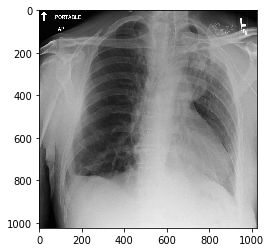

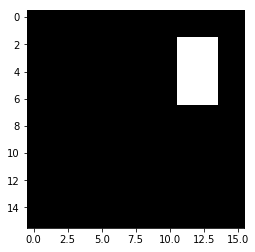

In [15]:
#check data generation
import random
X = np.array(X)
print('Shape of X: ',X.shape)
print('Shape of Output Y: ',np.array(Y_label_vectors).shape)

chp = random.choice(range(0,714))
plt.imshow(X[1].reshape(1024,1024),cmap = 'gray')
plt.show()
plt.imshow(np.array(Y_label_vectors)[1,:,:,0].reshape(16,16),cmap = 'gray')
plt.show()

In [16]:
X_test =[]
Y = np.zeros((16,16,1))
Y_backup = np.zeros((16,16,1))
Y_label_vectors_test=[]
classification_test=[]

#Randomizing the images
select_images_test = list(range(129))

N_img = 1

for i in select_images_test: #the random output index
    img_name = test_csv_output[i][0]
    xmin = float(test_csv_output[i][4])
    ymin = float(test_csv_output[i][5])
    xmax = float(test_csv_output[i][6])
    ymax = float(test_csv_output[i][7])
    disease_label = test_csv_output[i][3]
    
    #Loading the image
    img = scipy.misc.imread(os.path.join("test/",img_name))
    #print(img.shape)
    
    #Center of the nodule
    avg_x = (xmin+xmax)/2
    avg_y = (ymin+ymax)/2
    bh = ymax-ymin
    bw = xmax-xmin
    
    #Starting pixel values for 64x64 window sliding through the 1024 by 1024 image (16*16)
    nx = 0 
    ny = 0 
    #Moving horizontally through the original image
    
    for yaxis in range(0,16):
        #Starting sliding window from left side of the image 
        nx = 0 
        for xaxis in range(0,16): 
            
            #64 by 64 sub-image 
            window = img[ny:ny+64, nx:nx+64]
            #window starting and ending pixel coordinates 
            startx = nx
            starty = ny 
            endx = nx+63
            endy = ny+63

            #Checking if the center disease area is in the particular sub-image and recording the corresponding output pixel to be 1
            if startx >= (xmin-32) and endx <= (xmax+32) and starty >= (ymin-32) and endy <= (ymax+32):  
                #Setting output image pixel values 
                Y[yaxis,xaxis,0] = 1
            else: 
                Y[yaxis,xaxis,0] = 0
                
            if avg_x >= startx and avg_x <= endx and avg_y >= starty and avg_y <= endy:
                Y_backup[yaxis,xaxis,0] = 1
            else: 
                Y_backup[yaxis,xaxis,0] = 0
                
                
            #Moving horizontally
            nx = nx + 64
        #Moving Vertically
        ny = ny + 64
    #if no area in the bbox, use the area that at the center
    if np.array_equal(Y,np.zeros((16,16,1))):
        Y = Y_backup
    
    #Adding Y to the label vector 
    Y_label_vectors_test.append(Y)
    
    #print(Y_label_vectors)
    classification_test.append(disease_label_dict[disease_label])
    
    #Adding 1024 by 1024 image to the X vector
    try:
        X_test.append(img.reshape(1024,1024,1))
    except:
        print(img_name)
        
    #Re-initializing Y for the next original image 
    Y = np.zeros((16,16,1))
    Y_backup = np.zeros((16,16,1))
    
    #Keeping track of number of images
    if N_img%100 == 0 : 
        print('Collected '+str(N_img) +' Images and labels')
        
    N_img+=1

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Collected 100 Images and labels


Shape of X:  (129, 1024, 1024, 1)
Shape of Output Y:  (129, 16, 16, 1)


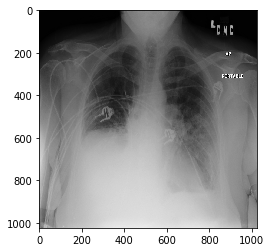

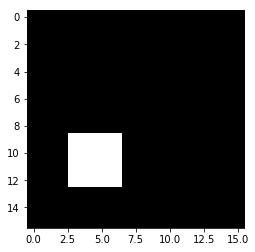

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
X_test = np.array(X_test)
print('Shape of X: ',X_test.shape)
print('Shape of Output Y: ',np.array(Y_label_vectors_test).shape)

chp = random.choice(range(0,129))
plt.imshow(X_test[1].reshape(1024,1024),cmap = 'gray')
plt.show()
plt.imshow(np.array(Y_label_vectors_test)[1,:,:].reshape(16,16),cmap = 'gray')
plt.show()
print(np.array(Y_label_vectors_test)[1,:,:].reshape(16,16))

In [18]:
import keras.backend as K
K.clear_session()
input_shape = (1024,1024,1)

In [19]:

model = Sequential([
    Conv2D(32, (3, 3),strides = (1,1), input_shape=input_shape, padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(32, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,   
    
    
    Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(64, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,
    
    
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(128, (3, 3),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,

    
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
     
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
     
    Conv2D(256, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None) ,

    
    Conv2D(128, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    Conv2D(64, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),

    
    Conv2D(32, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(16, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(8, (3, 3),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    
    Conv2D(1, (3, 3),strides = (1,1),padding='same',activation='sigmoid',name = 'output'),
    
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1024, 1024, 32)    320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 1024, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1024, 1024, 32)    9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_

In [20]:
#Cos-loss, not working
def loss_cosinesimilarity_entire(y_true,y_pred):
    return keras.losses.cosine_proximity(y_true, y_pred)

In [21]:
# square error
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [22]:
#Calculate cosine similarity. As 2 most similar vector results in cos similarity of 1, 1-cos.similar as output
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

In [23]:
def loss_myconv_entire(y_true,y_pred):
    
    y_true_flat_layer0 = K.flatten(y_true[:,:,:,0])
    y_pred_flat_layer0 = K.flatten(y_pred[:,:,:,0])
    
    #Logistic loss for the probabilities 
    logistic_loss = K.sum(-y_true_flat_layer0*(K.log(y_pred_flat_layer0)) - \
                          (1-y_true_flat_layer0)*(K.log(1-y_pred_flat_layer0)))
    return logistic_loss

In [24]:
#testing
from sklearn.metrics.pairwise import cosine_similarity
matric1 = np.array([0,0,0,0,1,1,1,0,0,1,0,1])
matric2 = np.array([1,1,1,0,0,0,1,0,1,0,0,0])
matric1 = np.reshape(matric1,(3,4))
matric2 = np.reshape(matric2,(3,4))
cos_matrix = cosine_similarity(matric1,matric2)
k = np.sum(cos_matrix)
print(cos_matrix)
print(k)

[[0.         0.         0.        ]
 [1.         0.57735027 0.57735027]
 [0.40824829 0.         0.        ]]
2.5629488288431146


In [25]:
#call back function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc =[]
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
    
    
# Create an instance of the history callback
history_cb = LossHistory()

In [26]:
k = np.array(Y_label_vectors)
print(k.shape)

(850, 16, 16, 1)


In [22]:
# Load model weights
json_string = pickle.load(open( "my_final_model.pkl", "rb" ) )
model_ = model_from_json(json_string)
model.load_weights('my_final_model_weights')

loss = pickle.load(open('my_final_loss.pkl','rb'))

In [27]:
#Complilation and fitting
opt= optimizers.Adam(lr = 0.005)
batch_size = 1
model.compile(loss='mean_squared_error', optimizer=opt)
print('Compiled')

model.fit(np.array(X), np.array(Y_label_vectors), batch_size=batch_size, epochs=5, verbose=1, validation_data=(np.array(X_test), np.array(Y_label_vectors_test)), callbacks = [history_cb])
print('Fitted')

Compiled
Instructions for updating:
Use tf.cast instead.
Train on 850 samples, validate on 129 samples
Epoch 1/5
850/850 [==============================] - 3488s 4s/step - loss: 0.0712 - val_loss: 0.0596
Epoch 2/5
850/850 [==============================] - 3475s 4s/step - loss: 0.0635 - val_loss: 0.0564
Epoch 3/5
850/850 [==============================] - 3474s 4s/step - loss: 0.0624 - val_loss: 0.0564
Epoch 4/5
850/850 [==============================] - 3477s 4s/step - loss: 0.0618 - val_loss: 0.0555
Epoch 5/5
850/850 [==============================] - 3476s 4s/step - loss: 0.0617 - val_loss: 0.0542
Fitted


In [87]:
#Save model weights
model.save('my_final_model_800pics.h5')
json_string = model.to_json()
model.save_weights('my_final_model_weights_800pics')

with open('my_final_model_800pics.pkl', 'wb') as jm:
    pickle.dump(json_string, jm)

with open('my_final_loss_800pics.pkl', 'wb') as lo:
    pickle.dump(history_cb.loss, lo)

In [186]:
loss = pickle.load(open('my_final_loss.pkl','rb'))

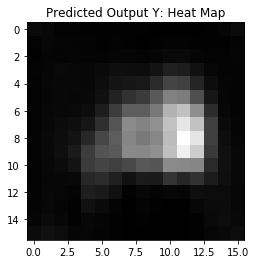

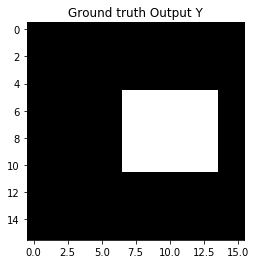

In [113]:
#testing
#choosing a random image
n = random.choice(range(0,100))

#predicting for the image with the trained model
yout = model.predict(X_test[n:n+1])
#print(yout)

#Plotting predicted output
plt.imshow(yout.reshape(16,16),cmap = 'gray')
plt.title('Predicted Output Y: Heat Map')
plt.show()
#print(yout)
# #Plotting Ground truth/Actual output
plt.imshow(np.array(Y_label_vectors_test)[n:n+1,:,:].reshape(16,16),cmap = 'gray')
plt.title('Ground truth Output Y')
plt.show()

#Evaluation
Calculated Overall Precision

In [90]:
#Precision
def precision_ind_image(index):
    yout = model.predict(X_test[index:index+1])
    sum_all_max=np.sum(yout)
    sum_all_min = np.sum(np.minimum(yout,np.array(Y_label_vectors_test)[index:index+1,:,:]))
    precision_index =sum_all_min/sum_all_max
    return precision_index

In [91]:
#strict Precision
total_precision = 0
for i in range(129):
    total_precision+=precision_ind_image(i)
confidence_all_area_precision = total_precision/129
print(confidence_all_area_precision)

0.17268795485609637


Precision: Bigger Bbox

In [92]:
#Precision
def accuracy_ind_image_big(index):
    yout = model.predict(X_test[index:index+1])
    sum_all_max=np.sum(yout)
    sum_all_label = np.sum(np.array(Y_label_vectors_test)[index:index+1,:,:])
    sum_all_min = np.sum(np.minimum(yout,np.array(Y_label_vectors_test)[index:index+1,:,:]))
    if sum_all_label<= 6:
        return "too small"
    else:
        accu_index = sum_all_min/sum_all_max
        return accu_index

In [93]:
num =0
total_accu = 0
for i in range(129):
    if accuracy_ind_image_big(i) == "too small":
        pass
    else:
        total_accu+=accuracy_ind_image_big(i)
        num+=1
    confidence_bigger_area_precision = total_accu/num
print(confidence_bigger_area_precision)

0.25421317531771087


Recall {0,1} Total

In [94]:
#Recall normalize total
def precision_ind_image(index):
    yout = model.predict(X_test[index:index+1])
    b=yout>0
    c = b.astype(int)
    sum_all_min = np.sum(np.minimum(c,np.array(Y_label_vectors_test)[index:index+1,:,:]))
    sum_all_label = np.sum(np.array(Y_label_vectors_test)[index:index+1,:,:])
    if sum_all_label == 0.0:
        sum_all_label = 1.0
    precision_index = sum_all_min/sum_all_label
    return precision_index

In [95]:
#strict precision(All Size)
total_precision = 0
for i in range(129):
    total_precision+=precision_ind_image(i)
all_area_normalize_recall = total_precision/128
print(all_area_normalize_recall)

1.0


#Recall with Confidence Total

In [96]:
#Recall
def precision_ind_image(index):
    yout = model.predict(X_test[index:index+1])
    sum_all_min = np.sum(np.minimum(yout,np.array(Y_label_vectors_test)[index:index+1,:,:]))
    sum_all_label = np.sum(np.array(Y_label_vectors_test)[index:index+1,:,:])
    if sum_all_label == 0.0:
        sum_all_label = 1.0
    precision_index = sum_all_min/sum_all_label
    return precision_index

In [97]:
#strict Recall(All Size)
total_precision = 0
for i in range(129):
    total_precision+=precision_ind_image(i)
all_area_confidence_recall = total_precision/128
print(all_area_confidence_recall)

0.21324014176893907


#Recall {0,1} >area

In [98]:
#Recall Larger Size
def precision_ind_image(index):
    yout = model.predict(X_test[index:index+1])
    b=yout>0
    c = b.astype(int)
    sum_all_min = np.sum(np.minimum(yout,np.array(Y_label_vectors_test)[index:index+1,:,:]))
    sum_all_label = np.sum(np.array(Y_label_vectors_test)[index:index+1,:,:])
    if sum_all_label <= 6:
        return "too small"
    else:
        precision_index = sum_all_min/sum_all_label
        return precision_index

In [99]:
#strict Recall(All Size)
total_precision = 0
num =0
for i in range(129):
    if precision_ind_image(i) == "too small":
        pass
    else:
        total_precision+=precision_ind_image(i)
        num+=1
larger_normalize_recall = total_precision/num
print(larger_normalize_recall)

0.24043279647293983


#Recall with Confidence > Area

In [88]:
#Recall Larger Size
def precision_ind_image(index):
    yout = model.predict(X_test[index:index+1])
    sum_all_min = np.sum(np.minimum(yout,np.array(Y_label_vectors_test)[index:index+1,:,:]))
    sum_all_label = np.sum(np.array(Y_label_vectors_test)[index:index+1,:,:])
    if sum_all_label <= 6:
        return "too small"
    else:
        precision_index = sum_all_min/sum_all_label
        return precision_index

In [89]:
#strict Recall(Larger Size)
total_precision = 0
num =0
for i in range(129):
    if precision_ind_image(i) == "too small":
        pass
    else:
        total_precision+=precision_ind_image(i)
        num+=1
larger_confidence_recall = total_precision/num
print(larger_confidence_recall)

0.24043279647293983


In [100]:
#F 1 Measure
#All Area Confidence F-1
f_1_measure = 2*all_area_confidence_recall*confidence_all_area_precision/(confidence_all_area_precision+all_area_confidence_recall)
print(f_1_measure)

0.19083349617366696


In [101]:
#Large Area Confidence F-1
f_1_measure = 2*larger_confidence_recall*confidence_bigger_area_precision/(confidence_bigger_area_precision+larger_confidence_recall)
print(f_1_measure)

0.24713103159676109
